In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import itertools
import numpy.matlib
import re

% matplotlib inline

## HH model

$\begin{aligned} C \frac { d V } { d t } & = - \overline { g } _ { L } \left( V - V _ { L } \right) - \overline { g } _ { \mathrm { Na } } m ^ { 3 } h \left( V - V _ { \mathrm { Na } } \right) - \overline { g } _ { \mathrm { K } } n ^ { 4 } \left( V - V _ { \mathrm { K } } \right) + I ( t ) \\ \frac { d n } { d t } & = \frac { 0.01 ( - V + 10 ) } { e ^ { ( - V + 10 ) / 10 } - 1 } ( 1 - n ) - 0.125 e ^ { - V / 80 } n \\ \frac { d m } { d t } & = \frac { 0.1 ( - V + 25 ) } { e ^ { ( - V + 25 ) / 10 } - 1 } ( 1 - m ) - 4 e ^ { - V / 18 } m \\ \frac { d h } { d t } & = 0.07 e ^ { - V / 20 } ( 1 - h ) - \frac { 1 } { e ^ { ( - V + 30 / 10 } + 1 } h \end{aligned}$

In [2]:
#parameters
gN = 120 #mmho/cm2
gK = 36 #mmho/cm2
gL = 0.3 #mmho/cm2
VN = 115 #mV
VK = -12 #mV
VL = 10.613 #mV
C = 1 #μF/cm2

/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


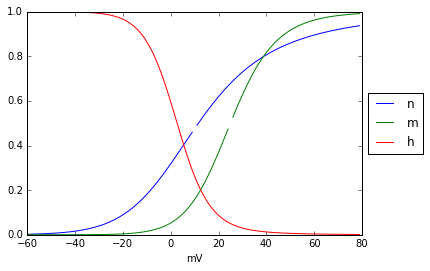

In [3]:
###equilibrium gating values
vv = np.arange(-60,80)
ne = 1 / (1 + 0.125*np.exp(-vv/80)/(0.01*(-vv+10)/(np.exp((-vv+10)/10)-1)))
me = 1 / (1 + 4*np.exp(-vv/18)/(0.1*(-vv+25)/(np.exp((-vv+25)/10)-1)))
he = 1 / (1 + (1/(np.exp((-vv+30)/10)+1))/(0.07*np.exp(-vv/20)))

plt.plot(vv,ne,label='n')
plt.plot(vv,me,label='m')
plt.plot(vv,he,label='h')
plt.xlabel('mV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


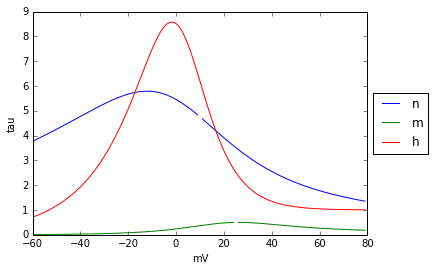

In [46]:
###equilibrium gating values
vv = np.arange(-60,80)
ne = 1 / (0.125*np.exp(-vv/80) + (0.01*(-vv+10)/(np.exp((-vv+10)/10)-1)))
me = 1 / (4*np.exp(-vv/18) + (0.1*(-vv+25)/(np.exp((-vv+25)/10)-1)))
he = 1 / ((1/(np.exp((-vv+30)/10)+1)) + (0.07*np.exp(-vv/20)))

plt.plot(vv,ne,label='n')
plt.plot(vv,me,label='m')
plt.plot(vv,he,label='h')
plt.ylabel('tau')
plt.xlabel('mV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [4]:
#initials
dt = 0.01
t = np.arange(0,50,dt)
I = np.zeros(len(t))#+20 #20
V = np.zeros(len(t))
V[0] = -65 #initialize near resting potential (this could be determined by running it with random inital conditions)
n = np.zeros(len(t))
m = np.zeros(len(t))
h = np.zeros(len(t))

In [5]:
#iteration for dynamics
for i in range(1,len(t)):
    V[i] = V[i-1] + dt*(I[i] - gN*m[i-1]**3*h[i-1]*(V[i-1]-VN) - gK*n[i-1]**4*(V[i-1]-VK) - gL*(V[i-1]-VL))/C
    
    n[i] = n[i-1] + dt*((1-n[i-1])*(0.01*(-V[i-1]+10)/(np.exp((-V[i-1]+10)/10)-1)) - n[i-1]*(0.125*np.exp(-(V[i-1])/80)))
    
    m[i] = m[i-1] + dt*((1-m[i-1])*(0.1*(-V[i-1]+25)/(np.exp((-V[i-1]+25)/10)-1)) - m[i-1]*(4*np.exp(-(V[i-1])/18)))
    
    h[i] = h[i-1] + dt*((1-h[i-1])*(0.07*np.exp(-(V[i-1])/20)) - h[i-1]*(1/(np.exp((-V[i-1]+30)/10)+1)))
    

0.0036435764467397944


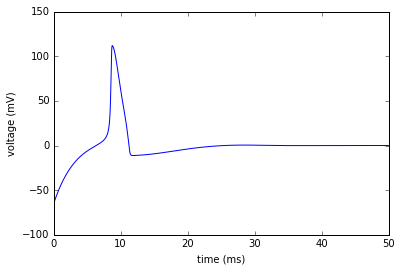

In [6]:
#plot traces of an action potential
plt.plot(t,V)
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)') 
print(V[-1])  #equilibrium/resting membran potential

In [7]:
def HH(I):
    for i in range(1,len(t)):
        V[i] = V[i-1] + dt*(I[i] - gN*m[i-1]**3*h[i-1]*(V[i-1]-VN) - gK*n[i-1]**4*(V[i-1]-VK) - gL*(V[i-1]-VL))/C

        n[i] = n[i-1] + dt*((1-n[i-1])*(0.01*(-V[i-1]+10)/(np.exp((-V[i-1]+10)/10)-1)) - n[i-1]*(0.125*np.exp(-(V[i-1])/80)))

        m[i] = m[i-1] + dt*((1-m[i-1])*(0.1*(-V[i-1]+25)/(np.exp((-V[i-1]+25)/10)-1)) - m[i-1]*(4*np.exp(-(V[i-1])/18)))

        h[i] = h[i-1] + dt*((1-h[i-1])*(0.07*np.exp(-(V[i-1])/20)) - h[i-1]*(1/(np.exp((-V[i-1]+30)/10)+1)))
        
    return V
    

In [8]:
from scipy.ndimage import measurements

def peak_finder(x0, thresh):
    '''
    A peak finding algorithm that considers neares possible points crossing a threshold.
    '''
    assert x0.ndim == 1
    clusters, ix = measurements.label(x0 > thresh)
    if ix==0:
        peak_loc = []
        peak_mag = []
    else:
        peak_loc = np.concatenate(measurements.maximum_position(x0, labels=clusters, index=np.arange(ix)+1))
        peak_mag = measurements.maximum(x0, labels=clusters, index=np.arange(ix)+1)
    return peak_loc, peak_mag

In [8]:
###find threshold and spike frequency
thr = 50
Is = np.logspace(0,np.log(60)/np.log(10),20) #different input current from 0 to 60 μA/cm2, sample in log space
spks = np.zeros(len(Is))
for i in range(0,len(Is)):
    II = Is[i]+np.zeros(len(t))
    vv = HH(II)
    peak_loc, peak_mag = peak_finder(vv, thr) #detect peaks
    if len(peak_loc)==1:
        spks[i] = 0
    else:
        spks[i] = len(peak_loc)

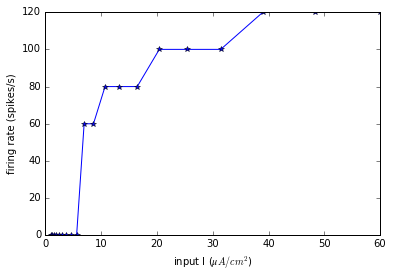

In [9]:
#plot nonlinear spike rate function
plt.plot(Is,spks/(50/1000),'-*') #convert spike counts in 50ms to firing rate
plt.ylabel('firing rate (spikes/s)')
plt.xlabel('input I ($μA/cm^2$)') 

In [10]:
#impedance of HH model under periodic drive
const = 4
ws = np.arange(0,0.3,0.02)  #frequency/1000
spks = np.zeros(len(ws))
for wi,ww in enumerate(ws):
    z = np.sin(ww*(np.pi*2)*t)
    II = const + z
    vv = HH(II)
    peak_loc, peak_mag = peak_finder(vv, thr) #detect peaks
    if len(peak_loc)==1:
        spks[wi] = 0
    else:
        spks[wi] = len(peak_loc)

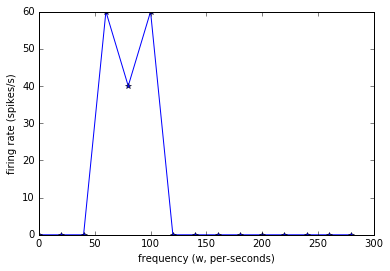

In [11]:
#plot frequnecy tuning
plt.plot(ws*1000,spks/(50/1000),'-*') #convert spike counts in 50ms to firing rate
plt.ylabel('firing rate (spikes/s)')
plt.xlabel('frequency (w, per-seconds)') 

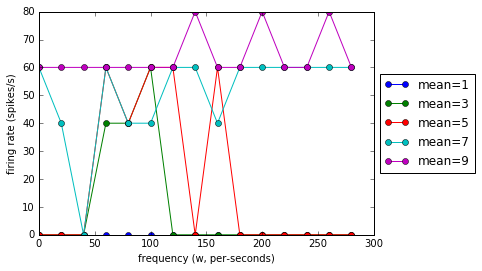

In [12]:
#changing mean
ms = np.arange(1,10,2)
for mm in ms:
    const = mm
    ws = np.arange(0,0.3,0.02)  #frequency/1000
    spks = np.zeros(len(ws))
    for wi,ww in enumerate(ws):
        z = np.sin(ww*(np.pi*2)*t)
        II = const + z
        vv = HH(II)
        peak_loc, peak_mag = peak_finder(vv, thr) #detect peaks
        if len(peak_loc)==1:
            spks[wi] = 0
        else:
            spks[wi] = len(peak_loc)
    plt.plot(ws*1000,spks/(50/1000),'-o',label='mean=%s'%mm) #convert spike counts in 50ms to firing rate

plt.ylabel('firing rate (spikes/s)')
plt.xlabel('frequency (w, per-seconds)') 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Propogating pulse along real axon

$I = \frac { a } { 2 R } \frac { \partial ^ { 2 } V } { \partial z ^ { 2 } }$

$\lambda^2 \frac{\partial^2 V_m(x,t)}{\partial x^2} = r_m c_m \frac{\partial V_m(x,t)}{\partial t} + (v_m(x,t)-v_{rest}) - r_m I_{inject}(x,t)$

In [9]:
#biophysical parameter
a = 250 *10**-4  #diameter (um to cm)
R = 35  #resistance (ohm per cm)
C = 1  #capacitance (uF per cm^2)
# ra = a/2/np.pi
# rm = 2*R/np.pi/a
# cm = C*np.pi*a/2

Vr = 0

In [10]:
L = 10  #cm (large accounting for the high speed)
T = 10  #ms (short duration to keep in range)
Nx = 1000
Nt = 300

In [42]:
###forward Eular numerical method for PDE
x = np.linspace(0, L, Nx+1)    # mesh points in space
dx = x[1] - x[0]
t = np.linspace(0, T, Nt+1)    # mesh points in time
dt = t[1] - t[0]
F = (a/2/R/C)*dt/dx**2  #1/(ra*rm)
v = np.zeros((Nt,Nx+1))          # voltage at (time X space)
I = np.zeros(Nx+1)+Vr
stim = np.zeros(Nx+1)
stim[:10] = 100  #spatial stimuli  (10 um)
stim_time = int(1/dt)   #timing until turn off  (0.1ms)

#gating variables
nn = np.zeros((Nt,Nx+1))
mm = np.zeros((Nt,Nx+1))
hh = np.zeros((Nt,Nx+1))

In [43]:
###PDE iteration
# Set initial condition u(x,0) = I(x)
#for i in range(0, Nx+1):
#    v_l[i] = I[i] #I(x[i])  #initial condition at t=0
v[0,:] = I.copy()

for n in range(1, Nt):  #time iteration
    # Compute v at inner mesh points
    for i in range(1, Nx):  #space iteration
        if n <=stim_time:
            v[n,i] = v[n-1,i] + F*(v[n-1,i-1] - 2*v[n-1,i] + v[n-1,i+1]) \
            + ( (- gN*mm[n-1,i]**3*hh[n-1,i]*(v[n-1,i]-VN) - gK*nn[n-1,i]**4*(v[n-1,i]-VK) - gL*(v[n-1,i]-VL))/(C) + stim[i]/C )*dt
        elif n>stim_time: #remove stimuli to prevend accumulating charge
            v[n,i] = v[n-1,i] + F*(v[n-1,i-1] - 2*v[n-1,i] + v[n-1,i+1])/C \
            + ( (- gN*mm[n-1,i]**3*hh[n-1,i]*(v[n-1,i]-VN) - gK*nn[n-1,i]**4*(v[n-1,i]-VK) - gL*(v[n-1,i]-VL))/(C) )*dt
        
        nn[n,i] = nn[n-1,i] + \
        ( (1-nn[n-1,i])*(0.01*(-v[n-1,i]+10)/(np.exp((-v[n-1,i]+10)/10)-1)) - nn[n-1,i]*(0.125*np.exp(-(v[n-1,i])/80)) )*dt
        
        mm[n,i] = mm[n-1,i] + \
        ( (1-mm[n-1,i])*(0.1*(-v[n-1,i]+25)/(np.exp((-v[n-1,i]+25)/10)-1)) - mm[n-1,i]*(4*np.exp(-(v[n-1,i])/18)) )*dt
                                                                          
        hh[n,i] = hh[n-1,i] + \
        ( (1-hh[n-1,i])*(0.07*np.exp(-(v[n-1,i])/20)) - hh[n-1,i]*(1/(np.exp((-v[n-1,i]+30)/10)+1)) )*dt

    # Insert boundary conditions
    v[n,0] = 0;  v[n,Nx] = 0
    nn[n,0] = 1;  nn[n,Nx] = 1
    mm[n,0] = 1;  mm[n,Nx] = 1
    hh[n,0] = 0;  hh[n,Nx] = 0
 

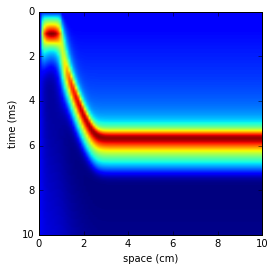

In [44]:
plt.imshow(v[:,:100],extent=[min(x), max(x), max(t), min(t)]);
plt.xlabel('space (cm)')
plt.ylabel('time (ms)')

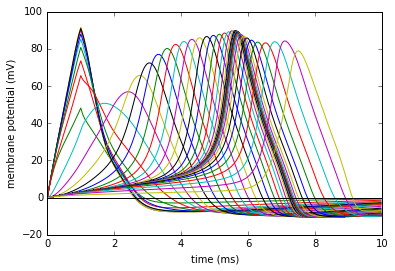

In [45]:
plt.plot(t[:-1],v);
plt.xlabel('time (ms)')
plt.ylabel('membrane potential (mV)')
###color represents recordings through space, therefore showing propogation of spikes

### Test code for 1-D diffusion equation with forward Eular method

In [29]:
a = 0.2
x = np.linspace(0, L, Nx+1)    # mesh points in space
dx = x[1] - x[0]
t = np.linspace(0, T, Nt+1)    # mesh points in time
dt = t[1] - t[0]
F = a*dt/dx**2
u   = np.zeros((Nt,Nx+1))           # unknown u at new time level

# Set initial condition u(x,0) = I(x,0)
u[0,400:500] = +1
u[0,500:600] = +2

for n in range(1, Nt):
    # Compute u at inner mesh points
    for i in range(1, Nx):
        u[n,i] = u[n-1,i] + F*(u[n-1,i-1] - 2*u[n-1,i] + u[n-1,i+1])

    # Insert boundary conditions
    u[n,0] = 0;  u[n,Nx] = 0


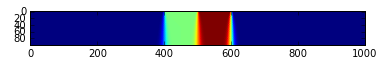

In [33]:
plt.imshow(u)